## Imports and various plotting utilities

This notebook uses [degas](https://github.com/williamgilpin/degas) for stylistic modifications only. The code is not necessary to run the notebook.


In [19]:
## Activate for dark plots
DARK = True

## Activate to save figures
SAVEFIG = True
SAVEFIG = False


import sys
import os
import json
import matplotlib.pyplot as plt


import seaborn as sns
sns.set_style()
import pandas as pd

# import dysts
from dysts.datasets import *
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

import degas as dg
dg.set_style()

FIGPATH = "../private_writing2/fig_resources/"
if DARK:
    plt.style.use("dark_background")
    FIGPATH += "dark_"
if not SAVEFIG:
    dg.better_savefig = lambda *args, **kwargs: None
    
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Plotting preliminaries
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
pastel_rainbow = np.array([
    [0.17254902, 0.45098039, 0.69803922],
    [0.19607843, 0.47843137, 0.5372549 ],
    [0.372549, 0.596078, 1],
    [0.16862745, 0.20392157, 0.48627451],
    [0.24705882, 0.58039216, 0.42745098],
    [0.65882353, 0.75294118, 0.86666667],
    [0.63921569, 0.85490196, 0.52156863],
    [0.72941176, 0.67843137, 0.83921569],
    [0.53333333, 0.62352941, 0.47843137],
    [0.64705882, 0.70588235, 0.52156863],
    [0.64313725, 0.14117647, 0.48627451],
    [0.92941176, 0.61568627, 0.24705882],
    [0.86666667, 0.23137255, 0.20784314],
    [1.0, 0.3882, 0.2784]
])

## Red strength sorting
sort_inds = np.argsort(pastel_rainbow[:, 0] / pastel_rainbow[:, -1])
sort_inds = np.argsort(pastel_rainbow[:, 0] / (pastel_rainbow[:, 2] + 0.5 * pastel_rainbow[:, 1]))
pastel_rainbow = pastel_rainbow[sort_inds]


pastel_rainbow = dg.color_sort(pastel_rainbow)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multivariate benchmarks

In [22]:
import os
import json

GRANULARITY = 100

with open(
    os.getcwd()
    + "/results/results_neural_ode_multivariate.json",
    "r",
) as file:
    all_results2 = json.load(file)

with open(
    os.getcwd()
    + "/results/results_test_multivariate__pts_per_period_100__periods_12.json",
    "r",
) as file:
    all_results1 = json.load(file)

with open(os.getcwd() + "/results/results_esn_multivariate.json", "r") as file:
    all_results_esn = json.load(file)

all_scores = dict()
for key in all_results1.keys():
    if key not in all_results2.keys():
        continue
    all_scores[key] = dict()
    for model_name in all_results1[key].keys():
        if model_name == "values":
            continue
        all_scores[key][model_name] = all_results1[key][model_name]["smape"]
    all_scores[key]["nODE"] = all_results2[key]["smape"]

    all_scores[key]["ESN"] = all_results_esn[key]["smape"]


all_scores = pd.DataFrame(all_scores).transpose()
all_scores_dict = all_scores.to_dict()

print(all_scores.shape)

# find mean and sort to get column names
mean_scores = all_scores.median(axis=0)
sort_order = np.argsort(np.array(mean_scores))
mean_scores = mean_scores.sort_values()
models_ranked = list(mean_scores.index)

(131, 14)


/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


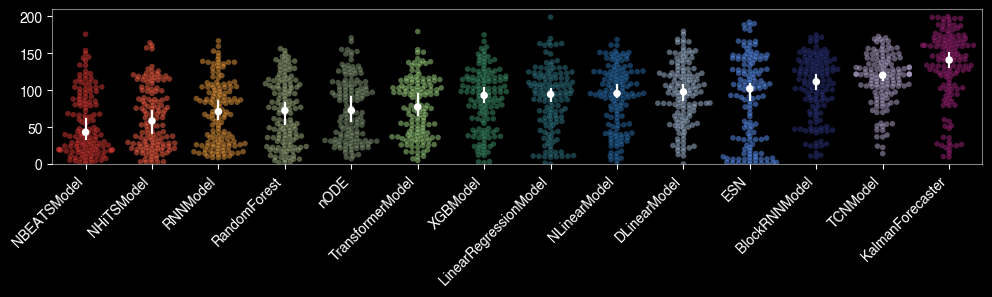

In [23]:

plt.figure(figsize=(12, 4))
# sns.violinplot(
#     data=all_scores2, 
#     zorder=0, 
#     fliersize=0, 
#     linewidth=0,
#     order=models_ranked, 
#     palette=pastel_rainbow[::-1]
# )
sns.swarmplot(
    data=all_scores,
    zorder=1,
    order=models_ranked,
    palette=pastel_rainbow,
    size=4,
    alpha=0.5,
)

sns.pointplot(
    data=all_scores,
    zorder=3,
    order=models_ranked,
    color='w',
    markers=".",
    # linestyles="",
    estimator=np.median,
    errorbar=('ci', 95),
    scale=1,
    errwidth=1.5,
    capsize=0.0,
    join=False,
)

# sns.boxplot(
#     data=all_scores,
#     zorder=2,
#     linewidth=0,
#     order=models_ranked,
#     color="w",
#     fliersize=0,
#     # boxprops=dict(alpha=0.5),
#     # medianprops=dict(alpha=0.5),
#     # whiskerprops=dict(alpha=0.5),
#     # capprops=dict(alpha=0.5),
# )
# plt.plot(np.arange(len(models_ranked)), mean_scores, ".w", zorder=10, markersize=10)

# tilt labels
plt.xticks(rotation=45, ha="right")
plt.ylim([0, None])

dg.fixed_aspect_ratio(1/6)

## dim the axes
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.5)

# ## dim the ticks
# plt.gca().xaxis.label.set_alpha(0.5)
# plt.gca().yaxis.label.set_alpha(0.5)
# plt.gca().tick_params(axis="x", alpha=0.5)
# plt.gca().tick_params(axis="y", alpha=0.5)
# # plt.gca().tick_params(axis="y", alpha=0.5)



dg.better_savefig(FIGPATH + "model_ranking.png")

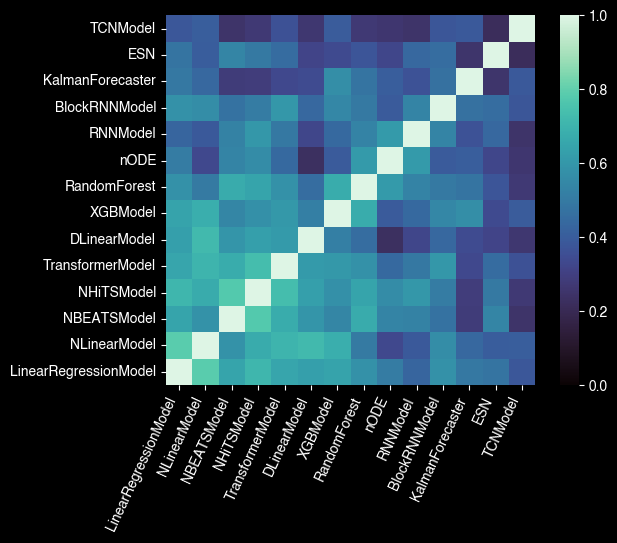

In [24]:
# plt.imshow(all_scores.corr(), vmin=0, vmax=1)
import seaborn as sns

## Sort the models by their correlation with the best model
corr_array = np.array(all_scores.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)
sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
all_scores = all_scores.iloc[:, sort_inds]

# plt.figure(figsize=(6, 6))
ax = sns.heatmap(all_scores.corr(method='spearman'), cmap="mako", vmin=0, vmax=1, square=True)
ax.invert_yaxis()
## tilt the x labels and center on tick
for item in ax.get_xticklabels():
    item.set_rotation(65)
    item.set_horizontalalignment("right")

# set font to helvetica
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')



# Best model on average
all_scores.mean(axis=0).sort_values()

dg.better_savefig(FIGPATH + "model_correlation.png")


In [25]:
## Timing results

## Load the timing results
fpath = "./results/results_test_multivariate__pts_per_period_100__periods_12.json_timing.json"
with open(fpath, "r") as file:
    all_timings = json.load(file)
print(len(all_timings.keys()))

## Load additional timing results
fpath = "./results/results_test_multivariate__pts_per_period_100__periods_12.json_timing_esn.json"
with open(fpath, "r") as file:
    all_timings2 = json.load(file)

## Drop unneeded keys
for item in all_timings.keys():
    # delete the "values" key if it exists
    if "values" in all_timings[item].keys():
        all_timings[item].pop("values")

## Merge the timing results
for key in all_timings2:
    all_timings[key].update(all_timings2[key])

## drop any incomplete entry
keys = list(all_timings.keys())
for key in keys:
    if len(all_timings[key]) != len(all_timings["Aizawa"]):
        print(key)
        all_timings.pop(key)

## Rename NODE to nODE
for key in all_timings.keys():
    all_timings[key]["nODE"] = all_timings[key].pop("NODE")

## invert inner and outer keys
timings = dict()
for model_name in all_timings["Aizawa"].keys():
    timings[model_name] = dict()
    for equation_name in all_timings:
        timings[model_name][equation_name] = all_timings[equation_name][model_name]

print(len(timings["RNNModel"]))

133
133


Skipping NBEATSModel AtmosphericRegime
Skipping NBEATSModel LidDrivenCavityFlow
NBEATSModel (r=-0.29)
Skipping NHiTSModel AtmosphericRegime
Skipping NHiTSModel LidDrivenCavityFlow
NHiTSModel (r=-0.34)
Skipping RNNModel AtmosphericRegime
Skipping RNNModel LidDrivenCavityFlow
RNNModel (r=0.05)
Skipping RandomForest AtmosphericRegime
Skipping RandomForest LidDrivenCavityFlow
RandomForest (r=-0.22)
Skipping nODE AtmosphericRegime
Skipping nODE LidDrivenCavityFlow
nODE (r=0.18)
Skipping TransformerModel AtmosphericRegime
Skipping TransformerModel LidDrivenCavityFlow
TransformerModel (r=-0.26)
Skipping XGBModel AtmosphericRegime
Skipping XGBModel LidDrivenCavityFlow
XGBModel (r=-0.18)
Skipping LinearRegressionModel AtmosphericRegime
Skipping LinearRegressionModel LidDrivenCavityFlow
LinearRegressionModel (r=0.07)
Skipping NLinearModel AtmosphericRegime
Skipping NLinearModel LidDrivenCavityFlow
NLinearModel (r=0.11)
Skipping DLinearModel AtmosphericRegime
Skipping DLinearModel LidDrivenCavity

/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_21924/3266450564.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f"$10^{{{int(y)}}}$" for y in plt.gca().get_yticks()])


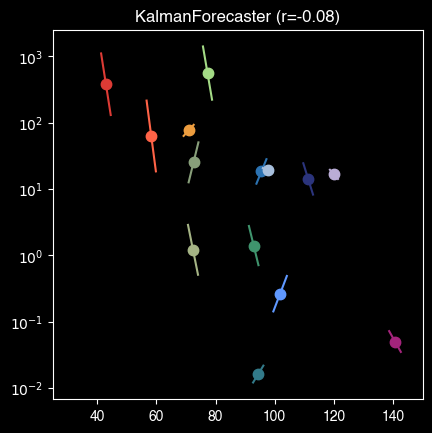

<Figure size 640x480 with 0 Axes>

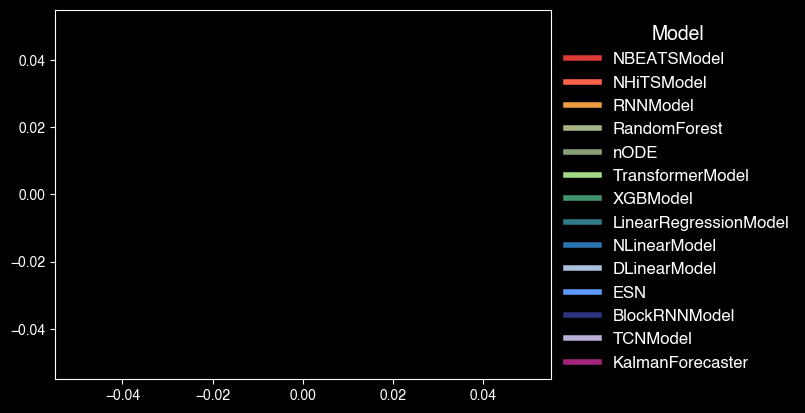

In [28]:
import degas as dg

from scipy.stats import spearmanr
all_mean_timings = dict()
all_all_pairs = list()
all_centers = list()
for i, model_name in enumerate(models_ranked):
    if model_name not in timings:
        print(f"Skipping {model_name}")
        continue

    all_pairs = list()
    for equation_name in timings[model_name]:
        try:
            time_val = float(timings[model_name][equation_name]["Train time"])
            # time_val = float(timings[model_name][equation_name]["Inference time"])
            error_val = float(all_scores_dict[model_name][equation_name])
            all_pairs.append((time_val, error_val))
        except KeyError:
            print(f"Skipping {model_name} {equation_name}")
            continue
    all_pairs = np.array(all_pairs)
    mean_time = np.median(all_pairs[:, 0])
    all_mean_timings[model_name] = mean_time
    all_pairs[:, 0] = np.log10(all_pairs[:, 0])
    all_pairs = all_pairs[:, ::-1]
    # plt.figure()
    # plt.plot(all_pairs[:, 0], all_pairs[:, 1], '.', markersize=2, alpha=0.1, color=pastel_rainbow[i])
    # plt.plot(all_pairs[:, 0], all_pairs[:, 1], '.', markersize=2, color=pastel_rainbow[i])
    plt.plot(
        np.median(all_pairs[:, 0]), np.median(all_pairs[:, 1]),
         '.', 
         markersize=15, 
         color=pastel_rainbow[i]
    )
    # dg.draw_ellipse(all_pairs, fill=True, edgecolor=None, alpha=0.5, facecolor=pastel_rainbow[i])
    dg.plot_cross(all_pairs, color=pastel_rainbow[i], center="median", slope="spearman", scale=0.02)
    # ax = sns.kdeplot(
    #     x=all_pairs[:, 0], 
    #     y=all_pairs[:, 1], 
    #     thresh=0.5,
    #     color=pastel_rainbow[i],
    #     shade=True, 
    #     bw_adjust=1.3, 
    #     levels=2,
    #     alpha=0.1,
    #     zorder=-1
    # )
    # ax = sns.kdeplot(
    #     x=all_pairs[:, 0], 
    #     y=all_pairs[:, 1], 
    #     fill=True,
    #     thresh=0.7,
    #     color=pastel_rainbow[i],
    #     shade=True, 
    #     bw_adjust=1.3, 
    #     levels=100,
    #     alpha=0.2,
    #     zorder=-1
    # )
    # sns.kdeplot(data=dataFrame, fill=True, thresh=0, levels=100, cmap="mako", cbar=True)

    # sns.displot(
    #     x=all_pairs[:, 0], 
    #     y=all_pairs[:, 1], 
    #     kind="kde",
    #     ax=plt.gca(),
    #     # thresh=0.7,
    #     color=pastel_rainbow[i],
    #     shade=True, 
    #     # bw_adjust=1.3, 
    #     # levels=2,
    #     # element="poly",
    #     alpha=0.2,
    #     zorder=-1
    # )
    # for contour in ax.collections[:]:
    #     contour.set_alpha(0.3)
    # draw_ellipse(plt.gca(), all_pairs, fill=False, edgecolor="red")
    title_str = f"{model_name} (r={spearmanr(all_pairs[:, 1], all_pairs[:, 0])[0]:.2f})"
    print(title_str)
    plt.title(title_str)

    all_all_pairs.append(all_pairs)
    all_centers.append(np.median(all_pairs, axis=0))

all_all_pairs = np.concatenate(all_all_pairs)
all_centers = np.array(all_centers)
# plt.plot(all_all_pairs[:, 0], all_all_pairs[:, 1], '.', markersize=9, alpha=0.04, color='w')
# ax = sns.kdeplot(
#     x=all_all_pairs[:, 0], 
#     y=all_all_pairs[:, 1], 
#     fill=True,
#     thresh=0.0,
#     color='w',
#     shade=True, 
#     bw_adjust=1.2, 
#     levels=8,
#     alpha=0.2,
#     zorder=-1
# )
# ax = sns.histplot(
#     x=all_all_pairs[:, 0], 
#     y=all_all_pairs[:, 1], 
#     fill=True,
#     thresh=0.7,
#     color='w',
#     alpha=0.2,
#     zorder=-1
# )

min_x, min_y = np.inf, np.inf
max_x, max_y = 0, 0
for item in plt.gca().get_lines():
    vals = item.get_xdata()
    min_x = min(min_x, np.min(vals))
    max_x = max(max_x, np.max(vals))
    vals = item.get_ydata()
    min_y = min(min_y, np.min(vals))
    max_y = max(max_y, np.max(vals))
# plt.xlim([min_x, max_x])
# plt.ylim([min_y, max_y])
# print(min_x, max_x, min_y, max_y)
plt.xlim([25, 150])

## bound to data
# plt.xlim([0, 1.05 * np.max(all_centers[:, 0])])
# plt.ylim([0.95 * np.min(all_centers[:, 1]), 1.1 * np.max(all_centers[:, 1])])

# plt.xlim([0, 1.05 * np.max(all_centers[:, 0])])

## Sort model names by mean time
all_mean_timings = pd.Series(all_mean_timings)
all_mean_timings = all_mean_timings.sort_values()
all_mean_timings = list(all_mean_timings.index)[::-1]
print(all_mean_timings)

# plt.xlim([0, None])
# rename y axis labels to logarithmic
plt.gca().set_yticklabels([f"$10^{{{int(y)}}}$" for y in plt.gca().get_yticks()])

## set aspect ratio of plot to perfect square
dg.fixed_aspect_ratio(1)

# dg.better_savefig(FIGPATH + "timing_vs_error_inference.png")
dg.better_savefig(FIGPATH + "timing_vs_error_training.png")


plt.figure()
plt.figure()
for i, model_name in enumerate(models_ranked):
    plt.plot([], color=pastel_rainbow[i], label=model_name)
# plt.legend()
# legend with thick lines
# get line2d

from matplotlib.lines import Line2D
plt.legend(
    handles=[
        Line2D([0], [0], color=pastel_rainbow[i], lw=4, label=model_name)
        for i, model_name in enumerate(models_ranked)
    ],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
    fontsize=12,
    title="Model",
    title_fontsize=14,
)

dg.better_savefig(FIGPATH + "timing_vs_error_legend.png")

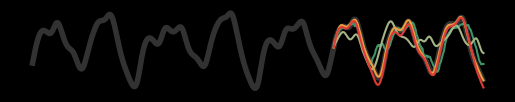

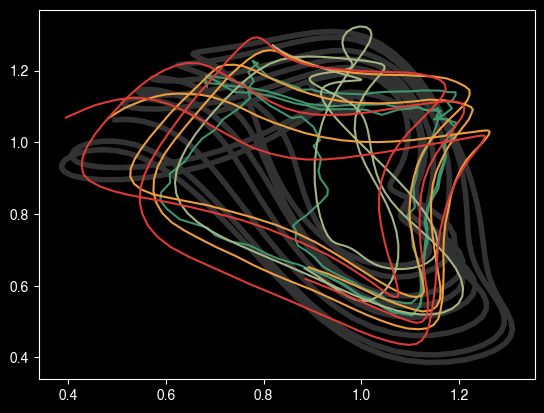

In [29]:
equation_name = "MackeyGlass"


from dysts.datasets import load_file
cwd = os.getcwd()
input_path = os.path.dirname(cwd) + "/dysts/data/test_multivariate__pts_per_period_100__periods_12.json.gz"
equation_data = load_file(input_path)

input_path = os.getcwd() + "/results/results_test_multivariate__pts_per_period_100__periods_12.json"
all_results = load_file(input_path)

prev_vals = np.array(equation_data.dataset[equation_name]["values"])
split_point = int(5/6 * len(prev_vals))
prev_vals = prev_vals[:split_point]

prev_vals = prev_vals[-400:]

true_vals = np.array(all_results[equation_name]["values"])

plt_models = models_ranked[:4]

plt.figure()
plt.plot(
    np.vstack([prev_vals, true_vals])[:, 0], 
    linewidth=4,
    zorder=-30,
    color=(1, 1, 1, 0.2)
)
for i, model_name in enumerate(plt_models):
    plt.plot(len(prev_vals) + np.arange(len(true_vals) + 1),
        np.array(all_results[equation_name][model_name]["prediction"])[:, 0],
        color=dg.pastel_rainbow[i],
        zorder=-i
    )
dg.vanish_axes()
dg.fixed_aspect_ratio(1/6)

dg.better_savefig(FIGPATH + f"forecast_examples_univariate_{equation_name}.png", dpi=800)

plt.figure()
plt.plot(
        np.vstack([prev_vals, true_vals])[:, 0], 
        np.vstack([prev_vals, true_vals])[:, 1], 
        linewidth=4,
        zorder=-30,
        color=(1, 1, 1, 0.2)
)
for i, model_name in enumerate(plt_models):
    plt.plot(
        np.array(all_results[equation_name][model_name]["prediction"])[:, 0],
        np.array(all_results[equation_name][model_name]["prediction"])[:, 2],
        color=dg.pastel_rainbow[i],
        zorder=-i
    )
# dg.vanish_axes()
# dg.fixed_aspect_ratio(1/6)


dg.better_savefig(FIGPATH + f"forecast_examples_multivariate_{equation_name}.png", dpi=800)

Text(0.5, 1.0, 'Spearman correlation = 0.37')

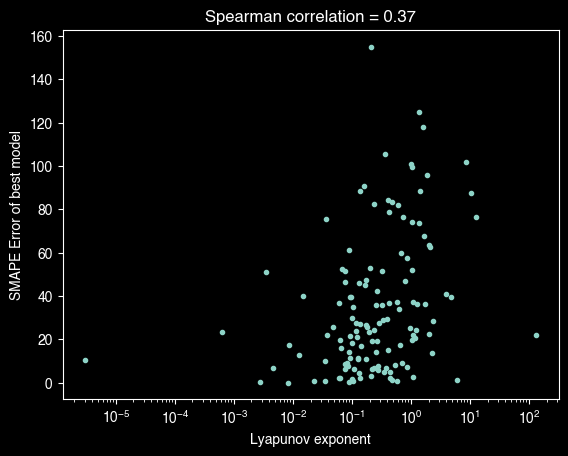

In [31]:
# best_scores = pd.DataFrame(all_scores["NBEATSModel"])
best_scores = pd.DataFrame(all_scores.min(axis=1).sort_values())
best_scores.columns = ["smape"]

# add column for lyapunov exponents
best_scores["lyapunov"] = np.nan * np.ones(best_scores.shape[0])

import dysts.flows as dfl

for equation_name in best_scores.index:
    eq = getattr(dfl, equation_name)()
    max_lyap = eq.maximum_lyapunov_estimated
    # score_val = all_results[equation_name]["smape"]
    best_scores.loc[equation_name, "lyapunov"] = max_lyap

plt.figure()
plt.semilogx(best_scores["lyapunov"], best_scores.iloc[:, 0], '.')
plt.xlabel("Lyapunov exponent")
plt.ylabel("SMAPE Error of best model")

from scipy.stats import spearmanr
corr_val = spearmanr(best_scores["lyapunov"], best_scores.iloc[:, 0])[0]
plt.title(f"Spearman correlation = {corr_val:.2f}")


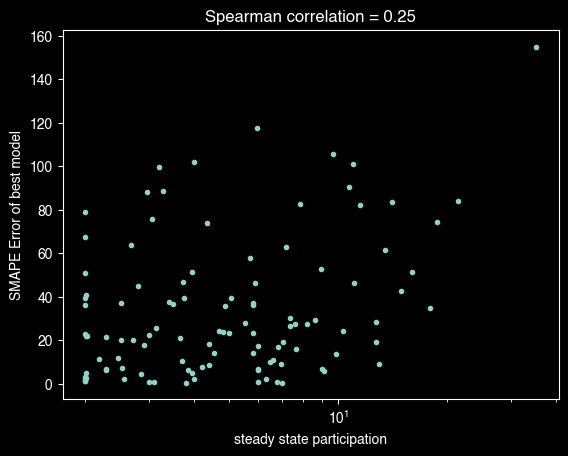

In [33]:
import pandas as pd
orbit_features = pd.read_csv("./resources/private_topo_features3.csv", index_col=0)

best_scores = pd.DataFrame(all_scores.min(axis=1).sort_values())
best_scores.columns = ["smape"]

## Merge the two dataframes
best_scores = orbit_features.merge(best_scores, left_index=True, right_index=True)
best_scores = best_scores.dropna()


for name in ['steady state participation']:

    plt.figure()
    plt.semilogx(best_scores[name], best_scores["smape"], '.')
    plt.xlabel(name)
    plt.ylabel("SMAPE Error of best model")

    from scipy.stats import spearmanr
    corr_val = spearmanr(best_scores[name], best_scores["smape"])[0]
    plt.title(f"Spearman correlation = {corr_val:.2f}")

## Long forecast task

In [20]:
## Load long forecasting dataset

import gzip

from dysts.metrics import smape
import dysts.flows as dfl
import json

## Load data from long forecasting task
fpath = os.getcwd() + "/results/results_test_multivariate__pts_per_period_100__periods_60.json.gz"
all_results = gzip.open(fpath, mode='r').read()
all_results = json.loads(all_results)

## Load and append neural ode results
fpath = os.getcwd() + "/results/results_neural_ode_multivariate__pts_per_period_100__periods_60.json.gz"
all_results_node = gzip.open(fpath, mode='r').read()
all_results_node = json.loads(all_results_node)
for key in all_results.keys():
    if key not in all_results_node.keys():
        continue
    all_results[key]["NODEModel"] = dict()
    all_results[key]["NODEModel"]["prediction"] = all_results_node[key]["traj_pred"]
    all_results[key]["NODEModel"]["smape"] = all_results_node[key]["smape"]

## Load and append echo state network results
fpath = os.getcwd() + "/results/results_esn_multivariate__pts_per_period_100__periods_60.json.gz"
all_results_esn = gzip.open(fpath, mode='r').read()
all_results_esn = json.loads(all_results_esn)
for key in all_results.keys():
    if key not in all_results_esn.keys():
        continue
    all_results[key]["ESNModel"] = dict()
    all_results[key]["ESNModel"]["prediction"] = all_results_esn[key]["traj_pred"]
    all_results[key]["ESNModel"]["smape"] = all_results_esn[key]["smape"]


In [2]:
## Compute the smape for each model (expensive)

all_outputs = dict()
for key in all_results:
    true_vals = np.array(all_results[key]["values"])
    all_traces = dict()
    for key2 in all_results[key]:
        if key2 == "values":
            continue

        pred_vals = np.array(all_results[key][key2]["prediction"])

        ## Some models fail to generate forecasts
        if np.any(pred_vals == None):
            continue
        
        ## probably need to exclude the maximum lookback window, since some models
        ## just learn a difference operator
        all_smapes = []
        for i in range(1, true_vals.shape[0]):
            true_vals_sub = true_vals[:i, :]
            pred_vals_sub = pred_vals[:i, :]
            smape_val = smape(true_vals_sub, pred_vals_sub)
            all_smapes.append(smape_val)
        all_traces[key2] = np.array(all_smapes)
    #all_traces = np.array(all_traces)
    all_outputs[key] = all_traces
    #all_outputs.append(all_traces)

    #all_outputs[key] = all_traces
    # all_output_scores[key] = dict()
    # all_output_scores[key]["mean"] = np.mean(all_traces, axis=0)
    # all_output_scores[key]["median"] = np.median(all_traces, axis=0)
    # all_output_scores[key]["min"] = np.min(all_traces, axis=0)

    # np.mean(np.array(all_traces), axis=0)
    # np.median(np.array(all_traces), axis=0)
    # np.min(np.array(all_traces), axis=0)




# save all outputs using json.dump and gzip
# save all outputs using json.dump
# import json, gzip
# with gzip.open('./resources/all_outputs_long_forecasting.json.gz', 'wt', encoding="utf-8") as file:
#     all_output_list = dict()
#     for key in all_outputs.keys():
#         all_output_list[key] = dict()
#         for key2 in all_outputs[key].keys():
#             all_output_list[key][key2] = all_outputs[key][key2].tolist()
#     json.dump(all_output_list, file, indent=4)


print(f"{len(all_lyaps)} systems")


NameError: name 'all_results' is not defined

In [21]:
## Load all outputs from cell above
import json, gzip
with gzip.open('./resources/all_outputs_long_forecasting.json.gz', 'rt', encoding="utf-8") as file:
    all_outputs = json.load(file)
    for key in all_outputs.keys():
        for key2 in all_outputs[key].keys():
            all_outputs[key][key2] = np.array(all_outputs[key][key2])

from scipy.stats import median_abs_deviation
all_smape_series = dict()
for model_name in all_outputs["Aizawa"].keys():
    all_smapes = []
    for equation_name in all_outputs.keys():
        if model_name not in all_outputs[equation_name].keys():
            print(f"skipping {model_name}")
            continue
        smape_val = all_outputs[equation_name][model_name]
        all_smapes.append(smape_val)
    all_smapes = np.array(all_smapes)

    all_smape_series[model_name] = dict()
    all_smape_series[model_name]["median"] = np.nanmedian(all_smapes, axis=0)
    all_smape_series[model_name]["p75"] = np.percentile(all_smapes, 75, axis=0)
    all_smape_series[model_name]["p25"] = np.percentile(all_smapes, 25, axis=0)
    all_smape_series[model_name]["mad"] = median_abs_deviation(all_smapes, axis=0)
    all_smape_series[model_name]["mean"] = np.nanmean(all_smapes, axis=0)
    all_smape_series[model_name]["stderr"] = np.nanstd(all_smapes, axis=0) / np.sqrt(all_smapes.shape[0])


skipping LinearRegressionModel


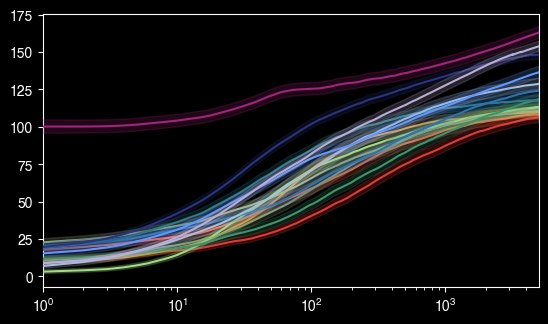

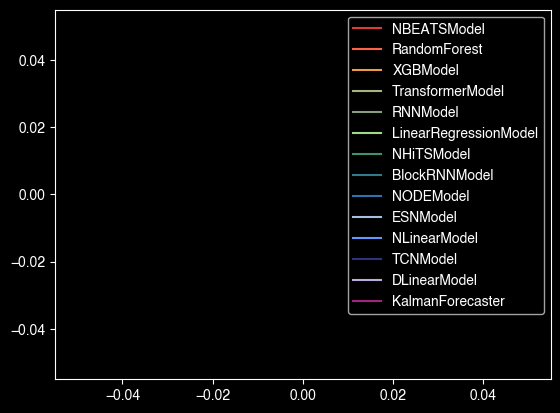

In [22]:

## rank all forecasting models in order of error
model_names = list(all_smape_series.keys())
all_smape_series_ranked = list()
for model_name in model_names:
    all_smape_series_ranked.append(all_smape_series[model_name]["mean"])
all_smape_series_ranked = np.array(all_smape_series_ranked)
all_smape_series_ranked = all_smape_series_ranked.argsort(axis=0).argsort(axis=0)
model_ranking = np.argsort(np.median(all_smape_series_ranked, axis=1))
model_names = np.array(model_names)[model_ranking]

## Plot all models mean and errors
for i, model_name in enumerate(model_names):
    plt.fill_between(
        np.arange(all_smape_series[model_name]["mean"].shape[0]),
        all_smape_series[model_name]["mean"] - all_smape_series[model_name]["stderr"],
        all_smape_series[model_name]["mean"] + all_smape_series[model_name]["stderr"],
        color=pastel_rainbow[i],
        alpha=0.2,
        zorder=100*i
    )
    plt.semilogx(all_smape_series[model_name]["mean"], color=pastel_rainbow[i], zorder=100*i+1)

## Square aspect ratio with logaritmic x-axis
plt.gca().set_aspect(1/2.0 / plt.gca().get_data_ratio(), adjustable='box')
plt.gca().set_xscale("log")
## tight xlim bounds to avoid white space
plt.xlim(1, all_smape_series[model_name]["mean"].shape[0])
dg.better_savefig(FIGPATH + "forecast_lengths_long.png", dpi=450)

## make a separate legend for the fill_between
plt.figure()
for i, model_name in enumerate(model_names):
    plt.plot([], color=pastel_rainbow[i], label=model_name)
plt.legend()
dg.better_savefig(FIGPATH + "forecast_lengths_legend.png", dpi=450)


In [23]:
import dysts.flows as dfl

max_lyap_times = list()
timepoint_grid = np.linspace(0, 1000, 1000)

all_prediction_results = dict()
for model_name in all_outputs["Aizawa"].keys():

    all_predictions = list()
    for equation_name in all_outputs:
        if model_name not in all_outputs[equation_name].keys():
            print(f"skipping {model_name}")
            continue
        eq = getattr(dfl, equation_name)()
        lyap = eq.maximum_lyapunov_estimated
        prediction = all_outputs[equation_name][model_name]
        time_vals = np.arange(prediction.shape[0])
        time_vals_lyap = lyap * time_vals
        max_lyap_times.append(time_vals_lyap[-1])
        # plt.semilogy(time_vals_lyap, prediction, color='w')

        cutoff_index = np.where(time_vals_lyap <= 1000)[0][-1]

        prediction_grid = np.zeros(len(timepoint_grid))
        prediction_resample = np.interp(
            timepoint_grid[:cutoff_index],
            time_vals_lyap[:cutoff_index], 
            prediction[:cutoff_index], 
        )
        prediction_grid[:cutoff_index] += prediction_resample
        prediction_grid[cutoff_index:] = np.nan
        all_predictions.append(prediction_grid)
    all_predictions = np.array(all_predictions)

    all_prediction_results[model_name] = all_predictions

## Print 10th and 90th percentile of Lyapunov exponent-scaled times
print(np.percentile(max_lyap_times, 10))
print(np.percentile(max_lyap_times, 50))
print(np.percentile(max_lyap_times, 90))

# average_prediction = np.nanmean(all_predictions, axis=0)
# error_prediction = np.nanmean(all_predictions, axis=0)


# plt.figure()
# plt.semilogx(timepoint_grid, average_prediction, color='w')
# plt.xlim([None, np.max(timepoint_grid)])

skipping LinearRegressionModel
116.02386576940467
1192.5778756117154
8383.75917405235


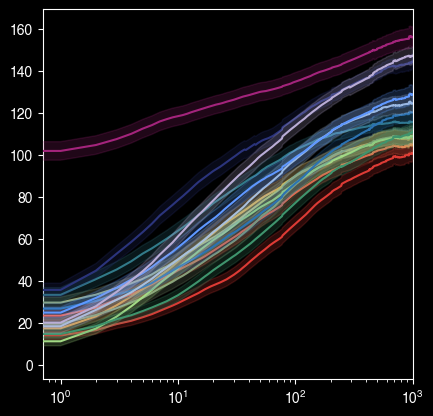

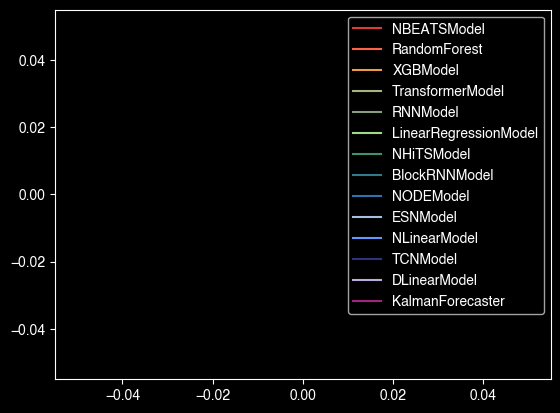

In [24]:
## Plot all models mean and errors
for i, model_name in enumerate(model_names):
    results_ave = np.nanmean(all_prediction_results[model_name], axis=0)
    results_std = np.nanstd(all_prediction_results[model_name], axis=0)
    results_dof = np.sum(~np.isnan(all_prediction_results[model_name]), axis=0)
    results_stderr = results_std / np.sqrt(results_dof)
    plt.fill_between(
        timepoint_grid,
        results_ave - results_stderr,
        results_ave + results_stderr,
        color=pastel_rainbow[i],
        alpha=0.2,
        zorder=100*i
    )
    plt.semilogx(results_ave, color=pastel_rainbow[i], zorder=100*i+1)

plt.xlim([None, np.max(timepoint_grid)])
dg.fixed_aspect_ratio(1, semilogx=True)

## make a separate legend for the fill_between
plt.figure()
for i, model_name in enumerate(model_names):
    plt.plot([], color=pastel_rainbow[i], label=model_name)
plt.legend()
# dg.better_savefig(FIGPATH + "forecast_lengths_legend.png", dpi=450)



0.5802865327706731
0.0757060839542753
0.0035097622587646343
0.09216197583296963
0.7164303367057223
0.450090505359164
0.010172128409635746
0.07287527454565443
0.48083152954373326
0.0794701998101797


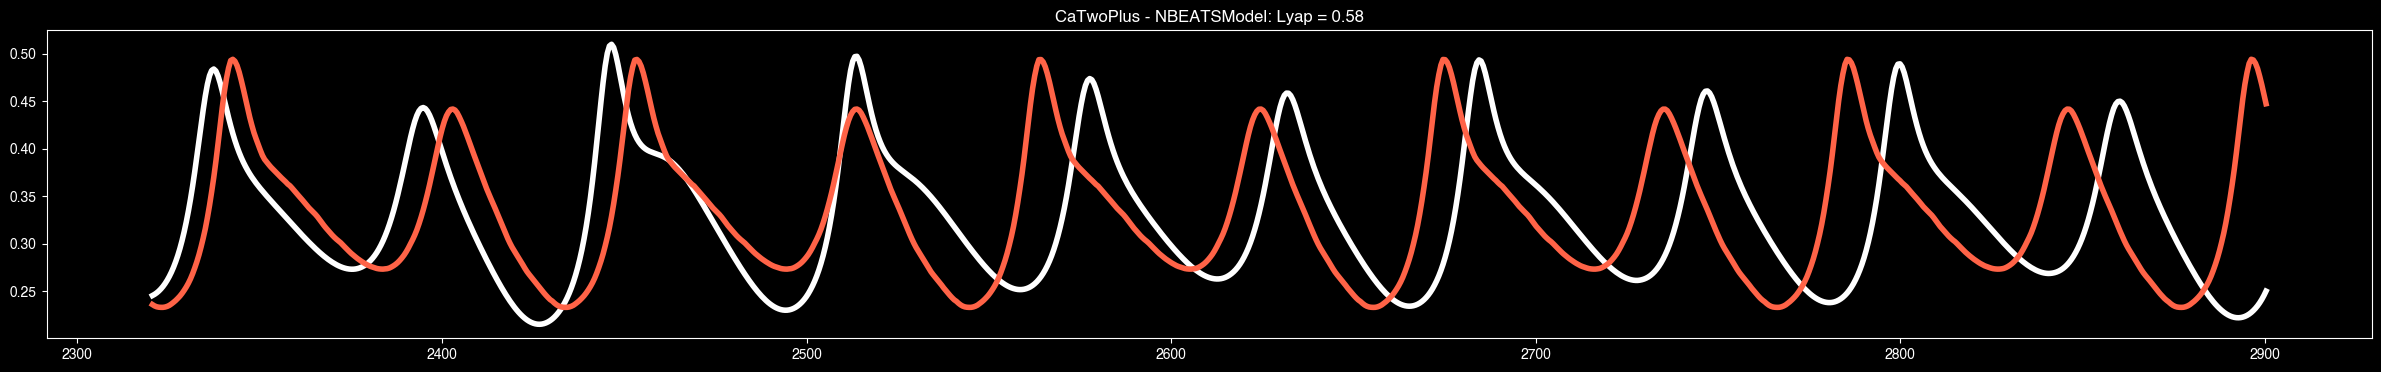

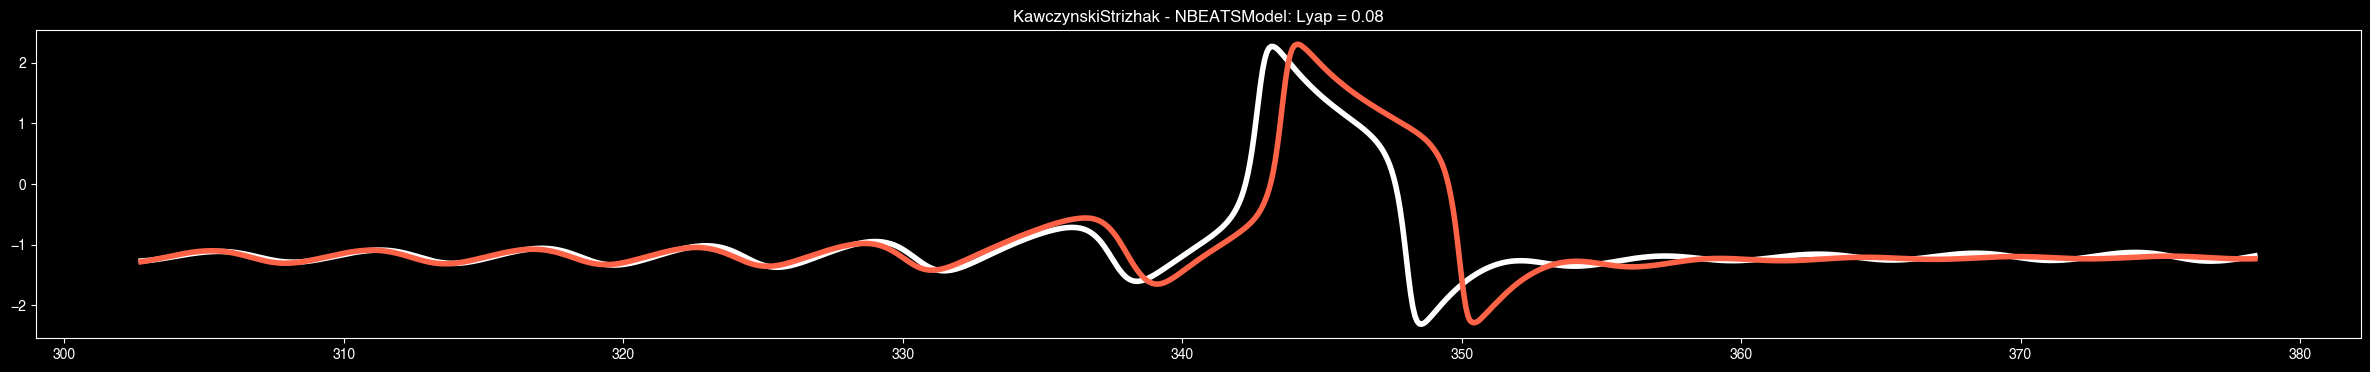

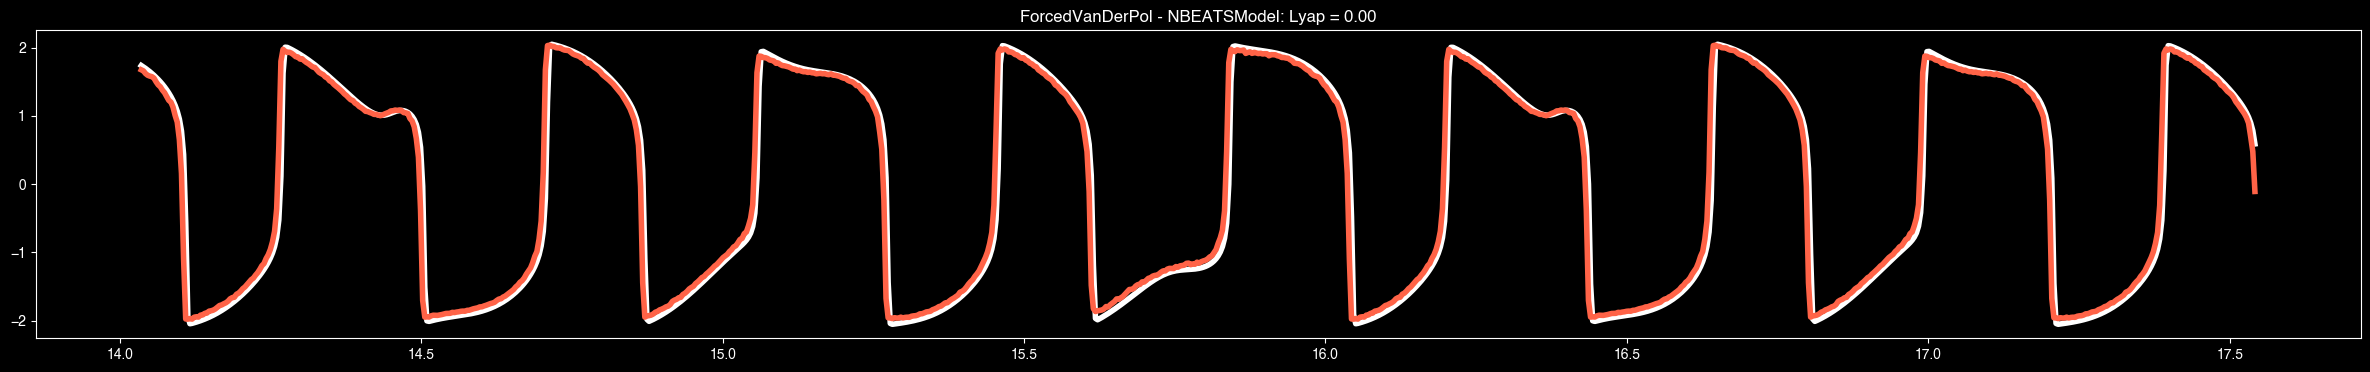

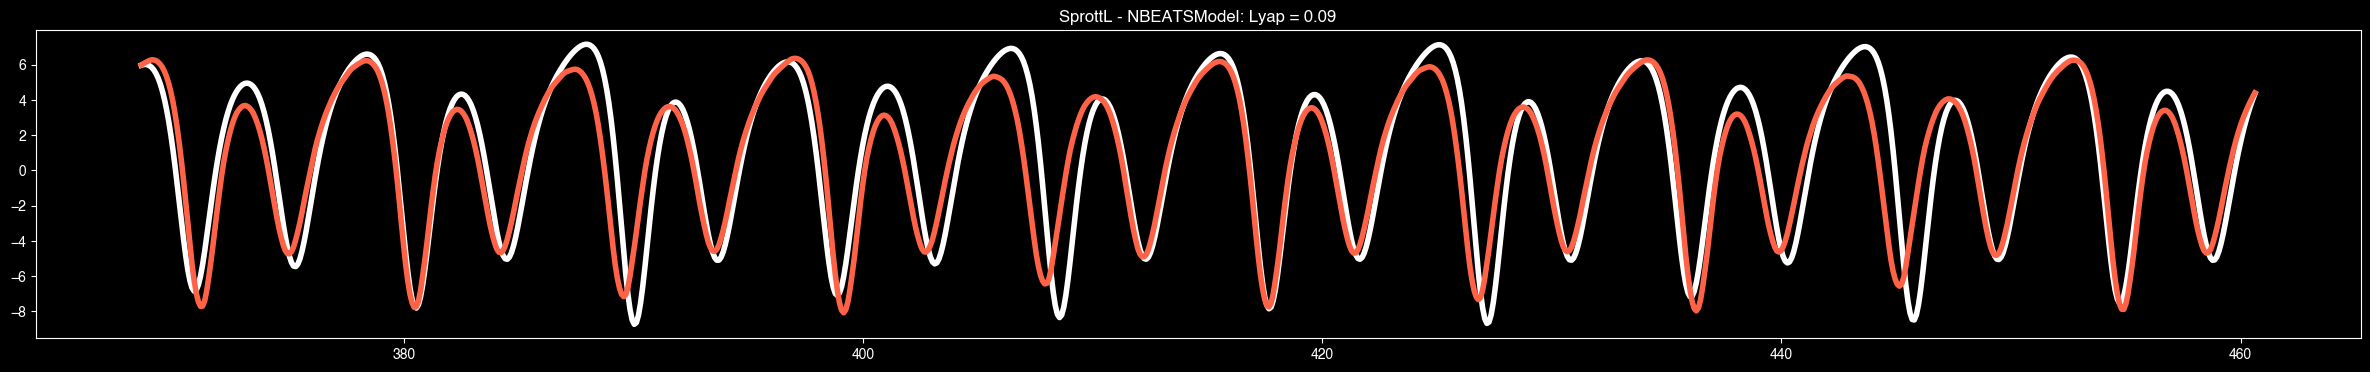

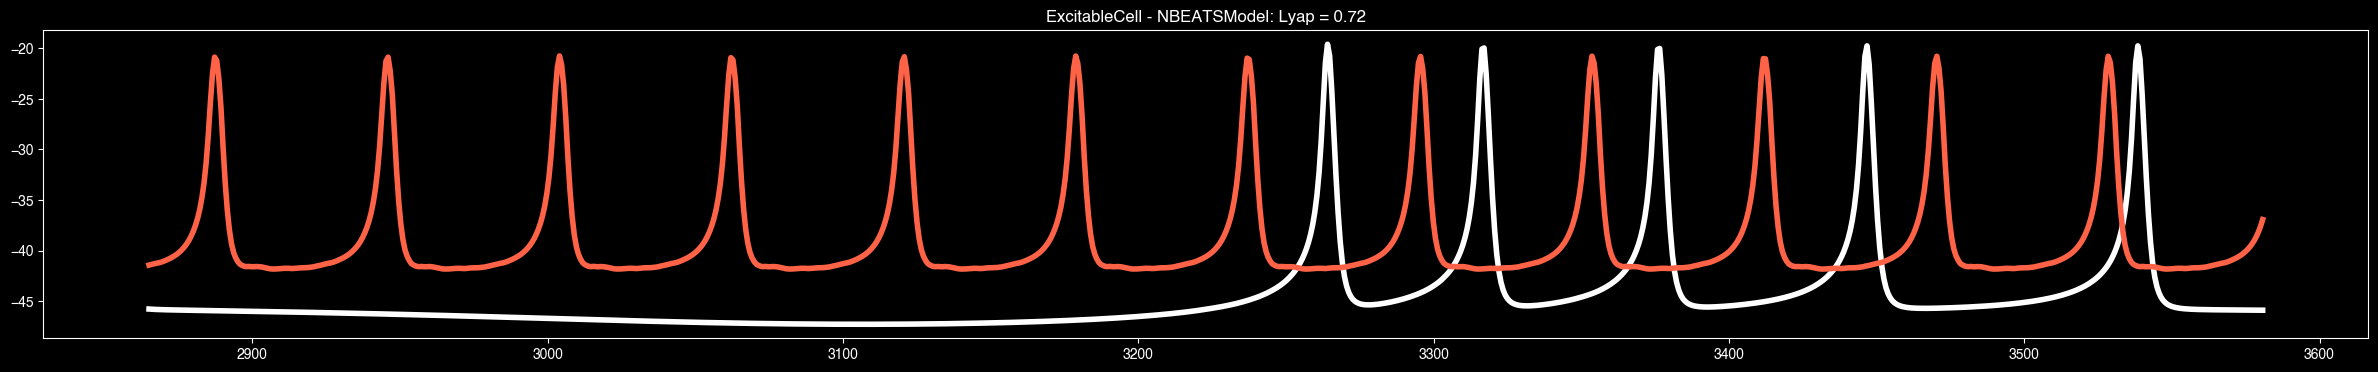

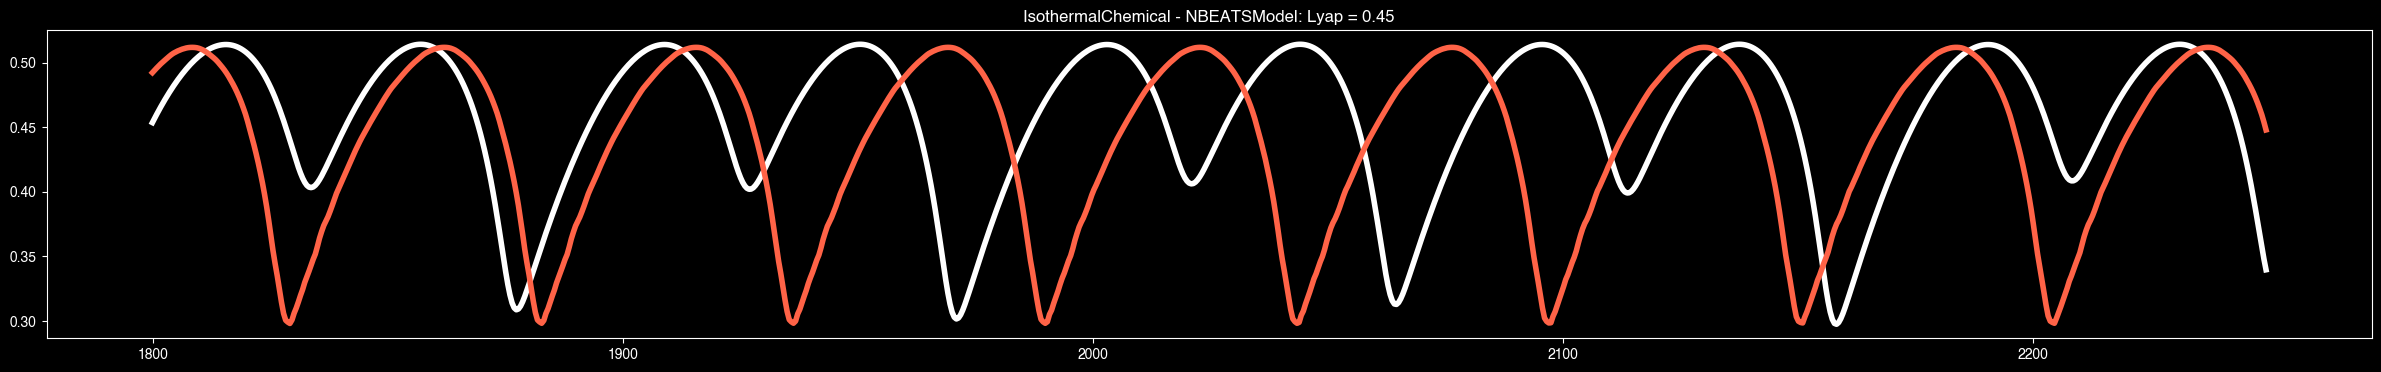

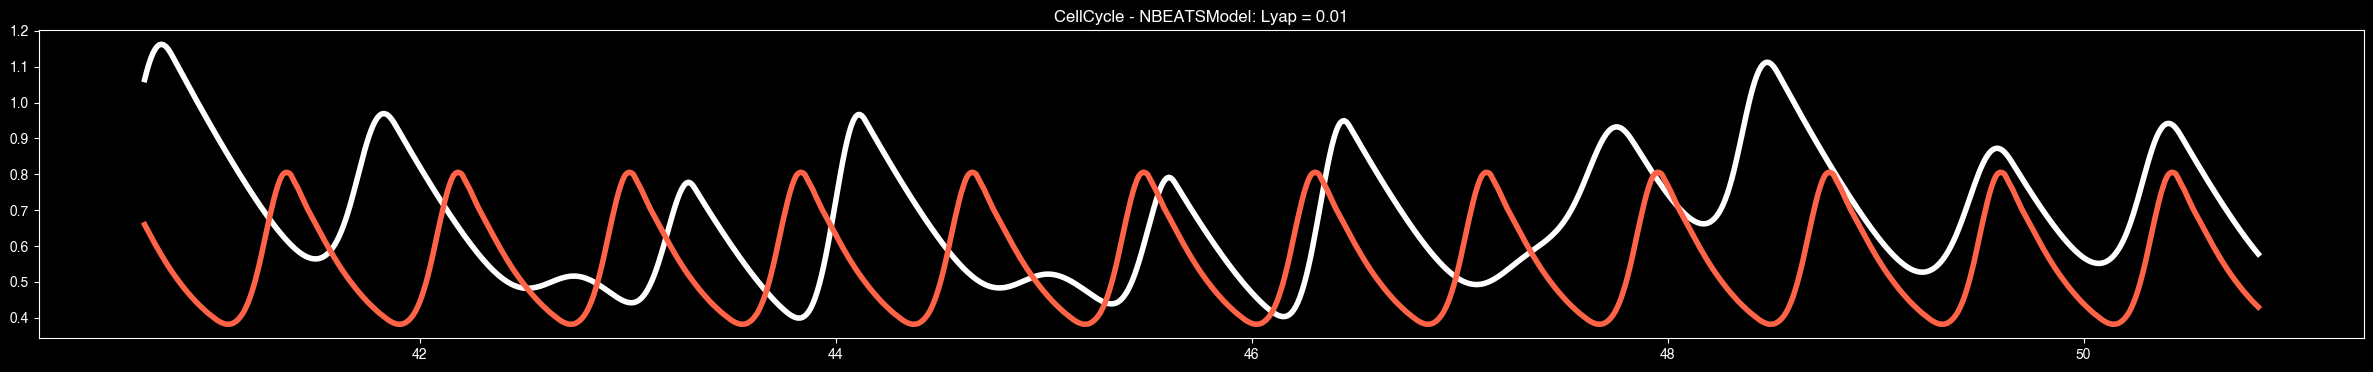

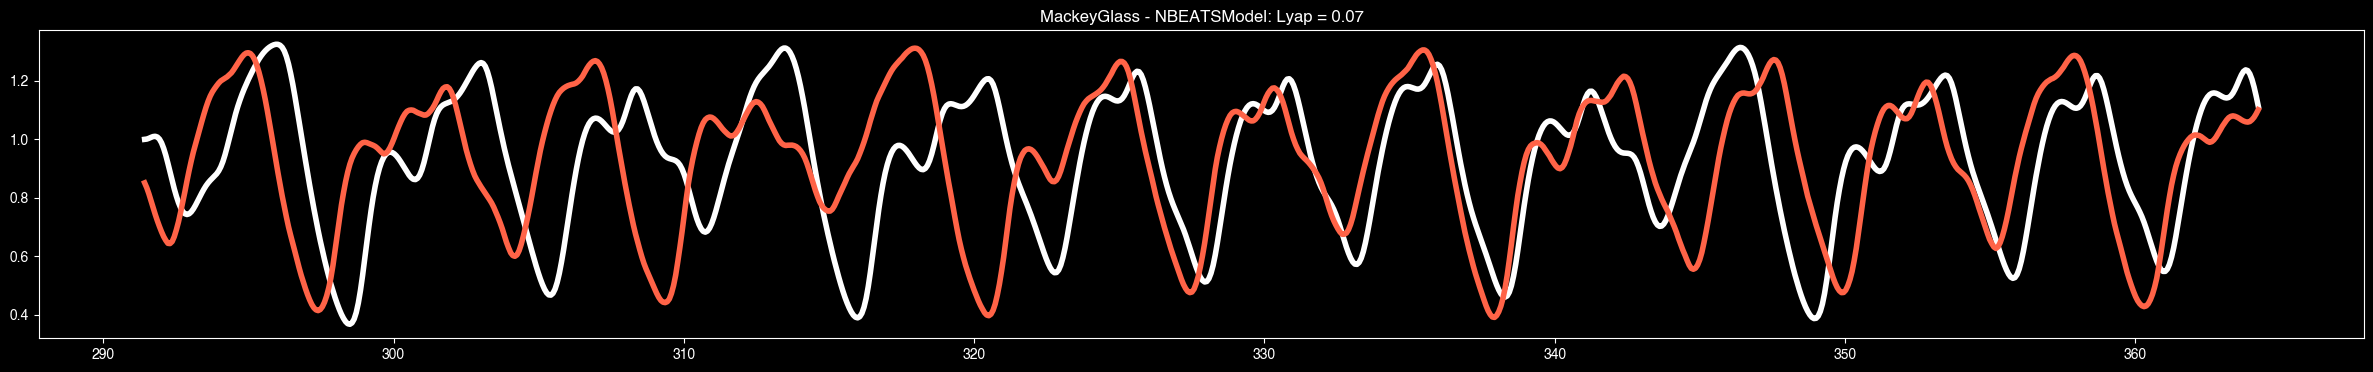

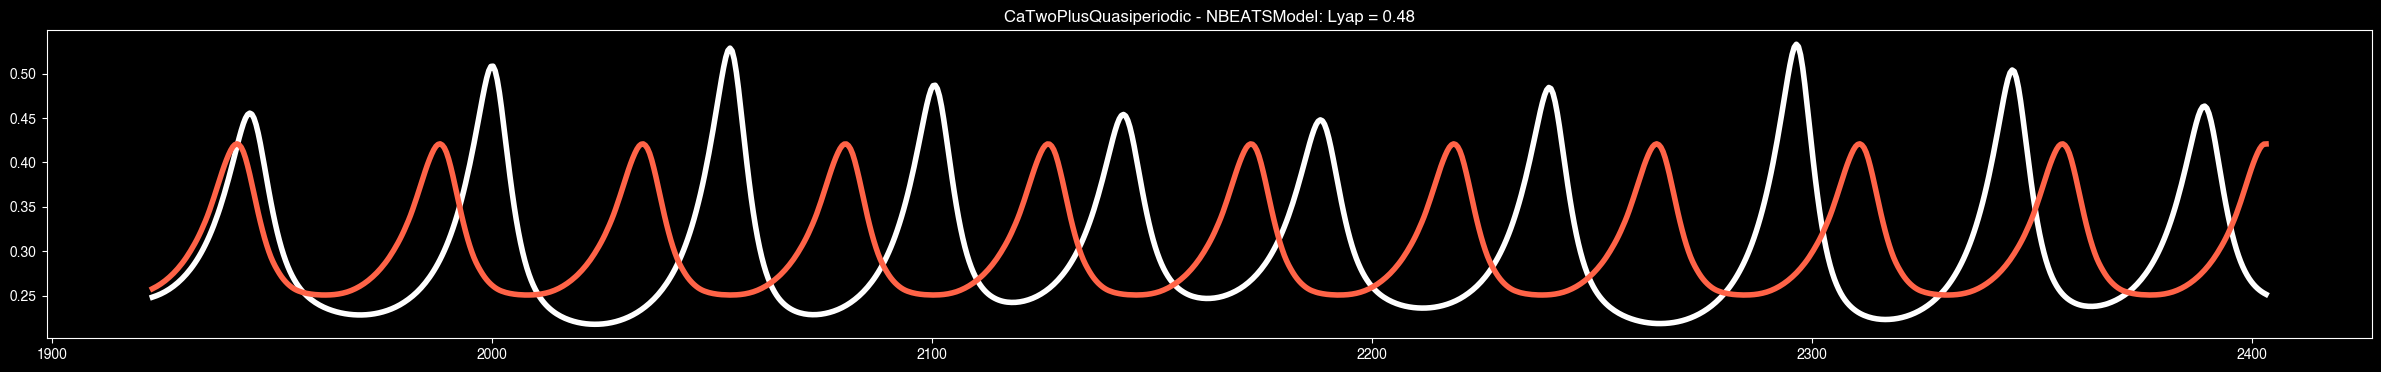

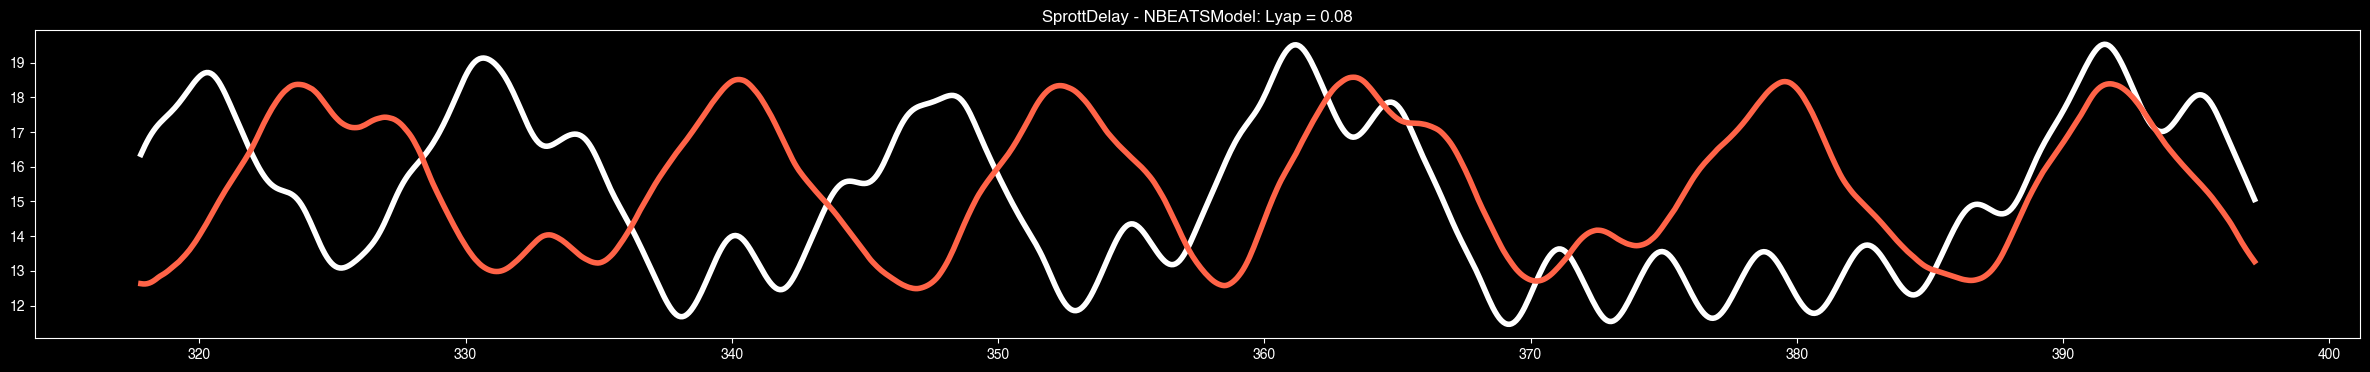

In [27]:

## Create a ranking of equations based on the SMAPE of the NBEATS model
equation_names =  np.array(list(all_results.keys()))
all_smapes = []
for equation_name in all_results:
    all_smapes.append(all_results[equation_name][model_name]["smape"])
equation_names = equation_names[np.argsort(np.array(all_smapes))]

## Plot the first 10 best-forecasted equations
model_name = "NBEATSModel"
for equation_name in equation_names[:10]:

    eq = getattr(dfl, equation_name)()
    lyap = eq.maximum_lyapunov_estimated
    print(lyap)

    true_values = np.array(all_results[equation_name]["values"])
    prediction = np.array(all_results[equation_name][model_name]["prediction"])

    plt.figure(figsize=(30, 4))
    plt.plot(np.arange(len(true_values))[-1000:] * lyap, true_values[-1000:, 0], color='w', linewidth=4)
    plt.plot(np.arange(len(true_values))[-1000:] * lyap, prediction[-1000:, 0], color=dg.red, linewidth=4)
    # dg.fixed_aspect_ratio(1 / 2.0)
    plt.title(f"{equation_name} - {model_name}: Lyap = {lyap:.2f}")


## Correlate properties with performance across time

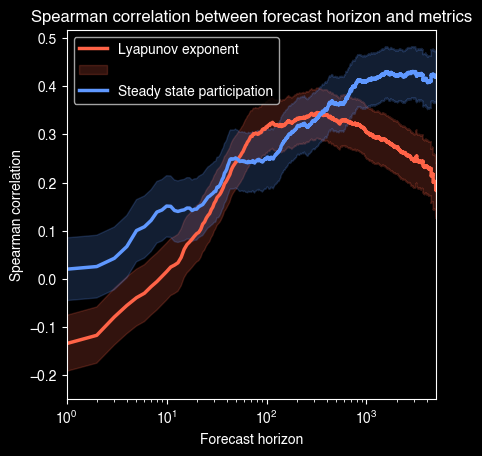

In [29]:
## try median aggregation as well

import dysts.flows as dfl

## Fetch all lyapunov exponents
all_lyaps = dict()
for equation_name in all_results.keys():
    eq = getattr(dfl, equation_name)()
    max_lyap = eq.maximum_lyapunov_estimated
    # score_val = all_results[equation_name]["smape"]
    all_lyaps[equation_name] = max_lyap
    

## aggregation across models
all_outputs_aggregated = dict()
for equation_name in all_results.keys():
    all_traces = list()
    for model_name in all_outputs[equation_name]:
        all_traces.append(all_outputs[equation_name][model_name])
    all_traces = np.array(all_traces)
    # all_traces = np.min(all_traces, axis=0)
    all_traces = np.mean(all_traces, axis=0)
    # all_traces = np.median(all_traces, axis=0)
    all_outputs_aggregated[equation_name] = all_traces


## Look up properties for each system and then correlate with the score
from scipy.stats import spearmanr
all_spearman = list()
for i in range(all_outputs_aggregated["Aizawa"].shape[-1]):
    all_spearman_sub, all_lyap_sub = list(), list()
    for equation_name in all_outputs_aggregated.keys():
        if equation_name not in all_lyaps.keys():
            continue
        lyap_val = all_lyaps[equation_name]
        score_val = all_outputs_aggregated[equation_name][i]
        all_spearman_sub.append(score_val)
        all_lyap_sub.append(lyap_val)
    corr_val = spearmanr(all_lyap_sub, all_spearman_sub)[0]
    all_spearman.append(corr_val)


## Look up properties for each system and then correlate with the score
import pandas as pd
from scipy.stats import spearmanr
orbit_features = pd.read_csv("./resources/private_topo_features3.csv", index_col=0)
orbit_features = orbit_features.transpose().to_dict()
## add lyapunov exponents
for equation_name in orbit_features:
    if equation_name in all_lyaps:
        orbit_features[equation_name]["lyapunov exponent"] = all_lyaps[equation_name]


plt.figure()
correlation_dict = dict()
# for metric_name in orbit_features["Aizawa"].keys():
for metric_name in ["lyapunov exponent", "steady state participation"]:

    all_spearman = list()
    all_spearman_std = list()
    for i in range(all_outputs_aggregated["Aizawa"].shape[-1]):
        all_spearman_sub, all_metric_sub = list(), list()
        for equation_name in all_outputs_aggregated.keys():
            if equation_name not in orbit_features.keys():
                continue
            metric_val = orbit_features[equation_name][metric_name]
            if np.isnan(metric_val):
                continue
            if metric_val == None:
                continue
            score_val = all_outputs_aggregated[equation_name][i]
            all_spearman_sub.append(score_val)
            all_metric_sub.append(metric_val)
        if len(all_spearman_sub) < int(0.7 * len(orbit_features)):
            print("Excessive missing values")
        corr_val = spearmanr(all_metric_sub, all_spearman_sub, nan_policy='omit')[0]
        all_spearman.append(corr_val)

        ## confidence interval via Fisher transformation 
        corr_err_up = np.tanh(np.arctanh(corr_val) + 0.674 / np.sqrt(len(all_spearman_sub) - 3))
        corr_err_down = np.tanh(np.arctanh(corr_val) - 0.674 / np.sqrt(len(all_spearman_sub) - 3))
        all_spearman_std.append([corr_err_down, corr_err_up])

    all_spearman = np.array(all_spearman)
    all_spearman_std = np.array(all_spearman_std)
    correlation_dict[metric_name] = dict()
    correlation_dict[metric_name]["spearman"] = all_spearman
    correlation_dict[metric_name]["spearman interval"] = all_spearman_std

red = [1.0, 0.3882, 0.2784]
blue = [0.372549, 0.596078, 1]
colors = [red, blue]
for i, metric_name in enumerate(correlation_dict.keys()):
    all_spearman = correlation_dict[metric_name]["spearman"]
    all_sperr = correlation_dict[metric_name]["spearman interval"]
    plt.semilogx(all_spearman, color=colors[i], linewidth=2.5)
    plt.fill_between(
        np.arange(len(all_spearman)),
        all_sperr[:, 0],
        all_sperr[:, 1],
        alpha=0.2,
        color=colors[i]
    )

# plt.legend(correlation_dict.keys())
plt.xlim([1, len(all_spearman)])
plt.gca().set_aspect(1.0 / plt.gca().get_data_ratio(), adjustable='box')
plt.gca().set_xscale("log")

plt.legend(["Lyapunov exponent", None, "Steady state participation"])

plt.xlabel("Forecast horizon")
plt.ylabel("Spearman correlation")
plt.title(f"Spearman correlation between forecast horizon and metrics")
# plt.savefig(
#     f"../private_writing2/fig_resources/forecast_horizon_correlation.png", 
#     dpi=300, 
#     bbox_inches="tight"
# )
dg.better_savefig(FIGPATH + "forecast_horizon_correlation..png", dpi=450)



# Appendix

## Lyapunov exponent calculation

In [ ]:
from dysts.analysis import lyapunov_exponent_naive#, get_attractor_list
from dysts.flows import *
import dysts.flows as dfl

# all_attractors = get_attractor_list()

# for equation_name in all_attractors:
#     eq = getattr(dfl, equation_name)()
all_names = []
for eq in [MackeyGlass(), Aizawa(), Lorenz()]:
    all_names.append(eq.name)
    tpts, sol1 = eq.make_trajectory(2000, resample=True, return_times=True)
    eq.ic *= (1 + 1e-12)
    sol2 = eq.make_trajectory(2000, resample=True)
    separation = np.linalg.norm(sol1 - sol2, axis=1)

    plt.semilogy(tpts, separation)
    lyap_est = np.polyfit(tpts, np.log(separation), 1)[0]
    print(f"{eq.name}: {lyap_est:.4f} ")

plt.legend(all_names)
# lyap = lyapunov_exponent_naive(eq, traj_length=200, n_samples=90)
# print(lyap)



In [ ]:
from dysts.analysis import lyapunov_exponent_naive
from dysts.flows import *

eq = MackeyGlass()
# a = 0.2, b = 0.1, c = 10, and T = 23
# eq = MackeyGlass()
eq.beta = 0.2
eq.gamma = 0.1
eq.n = 10
eq.tau = 23

# sol = eq.make_trajectory(4000, resample=True)
# plt.figure()
# plt.plot(sol[:, 0], sol[:, 1])
# eq.period /= 10
lyap = lyapunov_exponent_naive(eq, traj_length=2000, n_samples=20)
print(lyap)

In [19]:
from dysts.analysis import lyapunov_exponent_naive
from dysts.flows import *

eq = BlinkingVortex()
lyap = lyapunov_exponent_naive(eq) # 0.8917098035724058 0.2457084451352168
print(lyap)

# skipping BlinkingVortex
# skipping LiuChen
# skipping Lorenz

/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:282: UserWarning: Expect slowdown due to excessive integration required; scale factor 1194.7508832648352
  warnings.warn(
/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/base.py:309: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


In [ ]:
import json


with open("../dysts/data/chaotic_attractors.json", "r") as f:
    dataset = json.load(f)

# new values
with open("../dysts/data/lyapunov_exponents_naive_mean.txt", "r") as f:
    # load entries of hte form "equation_name: lyapunov_exponent" into a dict
    lyapunov_exponents = dict([line.split(": ") for line in f.read().splitlines()])
    # convert to float
    lyapunov_exponents = {k: float(v) for k, v in lyapunov_exponents.items()}

## update values
for key in dataset:
    if key in lyapunov_exponents:
        dataset[key]["maximum_lyapunov_estimated"] = lyapunov_exponents[key]
    else:
        print(f"skipping {key}")

## save
# with open("../dysts/data/chaotic_attractors.json", "w") as f:
#     json.dump(dataset, f, indent=4)


SpearmanrResult(correlation=0.8732614042933812, pvalue=1.785291220817327e-41)


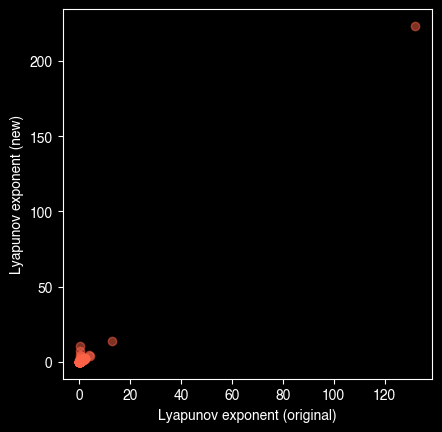

In [17]:
## Read lyapunov values from file
# with open("../dysts/data/lyapunov_exponents_qr.txt", "r") as f:
with open("../dysts/data/lyapunov_exponents_naive_mean.txt", "r") as f:
    # load entries of hte form "equation_name: lyapunov_exponent" into a dict
    lyapunov_exponents1 = dict([line.split(": ") for line in f.read().splitlines()])
    # convert to float
    lyapunov_exponents1 = {k: float(v) for k, v in lyapunov_exponents1.items()}

## Read lyapunov values from file
with open("../dysts/data/lyapunov_exponents_naive_short.txt", "r") as f:
    # load entries of hte form "equation_name: lyapunov_exponent" into a dict
    lyapunov_exponents2 = dict([line.split(": ") for line in f.read().splitlines()])
    # convert to float
    lyapunov_exponents2 = {k: float(v) for k, v in lyapunov_exponents2.items()}

all_pairs = []
for key in lyapunov_exponents1:
    if key in lyapunov_exponents2:
        all_pairs.append((lyapunov_exponents1[key], lyapunov_exponents2[key]))
all_pairs = np.array(all_pairs)

## Compare on a plot
plt.figure()
plt.scatter(all_pairs[:, 0], all_pairs[:, 1], color=dg.red, alpha=0.5)
plt.xlabel("Lyapunov exponent (original)")
plt.ylabel("Lyapunov exponent (new)")
from scipy.stats import spearmanr
print(spearmanr(all_pairs[:, 0], all_pairs[:, 1]))

dg.fixed_aspect_ratio(1)
